#install and import required packages

In [1]:
!pip install hazm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hazm
import string

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from hazm import WordTokenizer, Normalizer, Stemmer, stopwords_list, Lemmatizer
#pip show hazm
#Version: 0.9.3

#import data directly from kaggle

In [3]:
# Make sure the kaggle.json is present.
!ls -lha kaggle.json

# Install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d soheiltehranipour/snappfood-persian-sentiment-analysis

!unzip snappfood-persian-sentiment-analysis.zip

-rw-r--r-- 1 root root 67 Sep 17 13:44 kaggle.json
snappfood-persian-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  snappfood-persian-sentiment-analysis.zip
replace Snappfood - Sentiment Analysis.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Snappfood - Sentiment Analysis.csv  


#data exploration



In [4]:
df = pd.read_csv('Snappfood - Sentiment Analysis.csv', delimiter='\t')
print('shape of dataset: ', df.shape, '\n', '-------------')
print(df.info())

shape of dataset:  (70000, 4) 
 -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  520 non-null    object 
 1   comment     70000 non-null  object 
 2   label       70000 non-null  object 
 3   label_id    69480 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB
None


In [5]:
df.head(3)

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0


In [6]:
df.drop(df.columns[0], axis=1, inplace=True)
df.sample(3)

,comment,label,label_id
4849,سرد بود غذا فقط,HAPPY,0.0
31769,واقعا نا مناسب و بد مزه بود کباب کوبیده سوخته ...,SAD,1.0
3749,گوشت هات داگش واقعا جالب نبود. رنگش به سفیدی میزد,SAD,1.0


In [7]:
df.isnull().sum()

comment       0
label         0
label_id    520
dtype: int64

In [8]:
df[df['label_id'].isnull()].head(3)

,comment,label,label_id
21,SAD,1,NaN
89,SAD,1,NaN
161,SAD,1,NaN


In [9]:
df.dropna(axis=0, inplace=True)
df.isnull().sum()

comment     0
label       0
label_id    0
dtype: int64

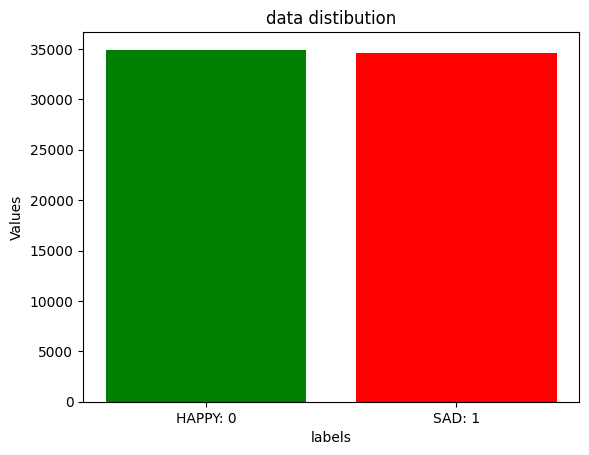

In [10]:
count_label = list(df['label_id'].value_counts())

colors = ['green', 'red']
plt.bar([0, 1], count_label, color= colors)

# Customize the tick markers or labels on the horizontal axis
new_labels = ['HAPPY: 0', 'SAD: 1']
plt.xticks([0, 1], new_labels)

# Add labels and title to the plot
plt.xlabel('labels')
plt.ylabel('Values')
plt.title('data distibution')

plt.show()


In [11]:
df['words_count'] = df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = df['words_count'].min() , df['words_count'].max()
print(f'Text Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Text Min: 2 	Max: 378


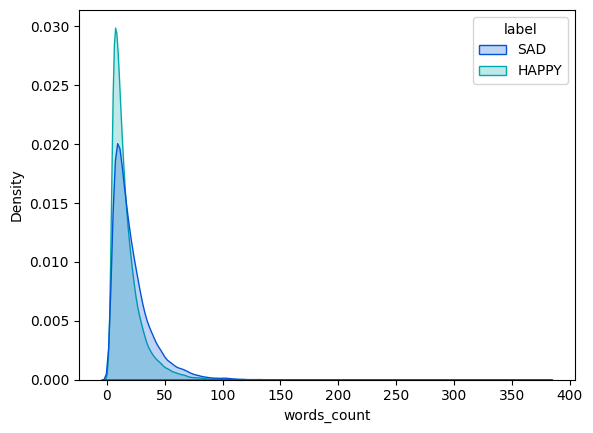

In [12]:
sns.kdeplot(x = df['words_count'], hue=df['label'], palette='winter', fill=True, warn_singular=False)
plt.show()

In [13]:
#df['comment'] = df['comment'].str.slice(stop=100)
#df.sample(3)

#data cleaning

In [13]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()
stopwords = stopwords_list()
punctuations = string.punctuation + "," + "،"

def normalize_text(text):
  translator = str.maketrans('', '', punctuations)
  normalized_text = normalizer.normalize(text)
  #test: add lemmatize
  #test: add len(word)>2
  #test: apply list of stopwords in github
  cleaned_text = [stemmer.stem(word.translate(translator)) for word in hazm.word_tokenize(normalized_text) if word not in stopwords]
  #update_cleaned_text = [word for word in cleaned_text if len(word)>2]
  #cleaned_text = [word.translate(translator) for word in hazm.word_tokenize(normalized_text) if word not in stopwords]
  return ' '.join(cleaned_text)
  #return update_cleaned_text.replace('#', ' ')


In [14]:
df['comment'].apply(normalize_text)

0                   واقعا حیف وق بنویس سرویس دهیتون افتضاح
1        قرار ۱ ساعته برسه ن ساع زود موقع  ببین چقدر پل...
2        قیم مدل اصلا کیفیت سازگار نداره  ظاهر فریبنده ...
3        درس اندازه کیف  امیداور کیفیتتون باشه مشتر همی...
4                                         شیرین وانیل مدل 
                               ...                        
69995    سلا فاکتور غذا سفار مید احتیاج دار موضوع قسم س...
69996                           سایز پیتزا سفارشات قبلا گذ
69997    قارچ اضافه اضافه کردهبود بود اضافه نمی‌کرد نمی...
69998                همرو ۲ ساع تاخیر اشتباه آوردن پول هوا
69999                                            فلفل تند 
Name: comment, Length: 69480, dtype: object

In [ ]:
from gensim.models import Word2Vec

tokenizer = hazm.WordTokenizer().tokenize
words_tokenized = []

for sentence in df['comment']:
  word_tokenized = tokenizer(sentence)
  words_tokenized.append(word_tokenized)

print(len(words_tokenized), '\n', '-----------', '\n', words_tokenized[0:3])

w2v_model = Word2Vec(words_tokenized, vector_size=100, window=5, min_count=1)  # Train Word2Vec model

embedded_comment = []
for sentence in words_tokenized:
    embedded_comment.append(sum([w2v_model.wv[word] for word in sentence]) / len(sentence))


In [28]:
X_train, X_test, y_train, y_test = train_test_split(embedded_comment, df['label_id'], test_size=0.2, random_state=42)

In [ ]:
#TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to CountVectorizer followed by TfidfTransformer.
#tokenizer = hazm.WordTokenizer().tokenize

#tfidf = TfidfVectorizer(use_idf=True, max_features=378, min_df=1, tokenizer=tokenizer)

#X_train = tfidf.fit_transform(X_train).toarray()
#X_test = tfidf.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
def train_model(model):
  cv_scores = cross_val_score(model, X_train, y_train, cv=5)
  #y_pred = model.predict(X_test)
  #return print(classification_report(y_test, y_pred))
  return print('accuracy:', cv_scores.mean())

In [ ]:
# Naive Bayes

nb = MultinomialNB()
train_model(nb)

In [31]:
# Random Forest

rf = RandomForestClassifier(n_estimators=100)
train_model(rf)

accuracy: 0.8285657915806242


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(5, 50),         # Maximum depth
    'min_samples_split': randint(2, 10),  # Minimum samples required to split
    'min_samples_leaf': randint(1, 10),   # Minimum samples required at leaf nodes
    'max_features': ['sqrt', 'log2'],     # Number of features to consider
    'class_weight': [None, 'balanced']    # Class weights
}

# Create a Random Forest model
rf = RandomForestClassifier()

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

In [32]:
# XGBoost

xgb = XGBClassifier()
train_model(xgb)

accuracy: 0.8303647879146542


In [ ]:
#Logistic Regressian

lr = LogisticRegression(max_iter=100)
train_model(lr)

In [ ]:
svc = SVC()
train_model(svc)

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      6899
         1.0       0.81      0.90      0.86      6997

    accuracy                           0.85     13896
   macro avg       0.85      0.85      0.85     13896
weighted avg       0.85      0.85      0.85     13896



In [34]:
knn = KNeighborsClassifier(n_neighbors=7)
train_model(knn)

accuracy: 0.8126078493260034
